# 6_Filtros: Multirate 

Para poder mejorar la velocidad de procesamiento y disminuir el costo computacional de realizar un filtrado mediante la sustracción de la linea de base estimada con el método de mediana móvil desarrollado en el script anterior se aplica la técnica de Multirate. Esta técnica consiste en resamplear la señal a una frecuencia menor, para la elección de esta frecuencia hay que tener en cuenta el rango de frecuencias en el que se encuentra la linea de base. Este rango se puede obtener por ejemplo del cálculo del espectro en frecuencia de la estimación realizada en el 4_. Vamos a elegir como nueva frecuencia 25Hz, ya que es un diezmado suficiente, podría ser menor pero así se logra una buena reducción del costo computacional a la hora de realizar el método de mediana móvil, sin acomplejar demasiado el procesamiento para llevar a cabo la técnica de Multirate y manteniendo una buena estimación de la señal.

La frecuencia de muestreo de la señal que se utliza de ejemplo es 1000Hz, por lo tanto el factor diezmado es 40. Es aconsejable en los casos donde el factor de diezmado es mayor a 10 dividir el problema en etapas, por ejemplo un de 10 y una de 4, o una de 5 y otra de 8


In [2]:
#------Modulos-------
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy.io as sio
import scipy.signal as sig
import scipy.interpolate as interpol
import time

import paquete.moduloSeñales as myS
import paquete.moduloFiltrado as myF

import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import DataFrame
from IPython.display import HTML
mpl.rcParams['figure.figsize'] = (15,12)    

In [3]:
#------Apertura-------
ecg_one_lead, cant_muestras, fs, nyq_frec, _ = myS.obtenerSeñal('/home/luciasucunza/git_proyecto_ecg/Filtros/TP4_ecg.mat')
t        = np.arange(cant_muestras) / fs


In [4]:
#------Parametros de Diezmado-------
f_B         = 7

fs_old_1    = fs
fs_new_1    = 100
nyq_frec_1  = fs_old_1/2

fs_old_2    = fs_new_1
fs_new_2    = 25
nyq_frec_2  = fs_old_2/2

fs_old_3    = fs_new_2
fs_new_3    = fs_old_1
nyq_frec_3  = fs_old_3/2


D   = int(fs_old_1 / fs_new_2)
D1  = int(fs_old_1 / fs_new_1)
D2  = int(fs_old_2 / fs_new_2)

In [5]:
#------Diseños de Filtros-------

#------LPF 10-------
wpb_p_1         = f_B               #Hz
wpb_s_1         = fs_new_1/2        #Hz
cant_coef_1     = 151

fir_coeff_pb_1 = myF.diseñoPB( fs, wpb_p_1, wpb_s_1, cant_coef_1)

#------LPF 4-------
wpb_p_2         = f_B           #Hz
wpb_s_2         = fs_new_2/2    #Hz
cant_coef_2     = 41

fir_coeff_pb_2 = myF.diseñoPB( fs, wpb_p_2, wpb_s_2, cant_coef_2)

In [6]:
#------Primer Filtrado-------
ECG_Filt_1 = sig.lfilter(fir_coeff_pb_1, 1, ecg_one_lead)

#------LPF 10-------
ECG_Diez_1 = np.zeros(int(cant_muestras/D1), dtype=float)

for i in range(int(cant_muestras/D1)) :
        ECG_Diez_1[i] = ECG_Filt_1[i*D1]

#------Segundo Filtrado-------
ECG_Filt_2 = sig.lfilter(fir_coeff_pb_2, 1, ECG_Filt_1)

#------LPF 4-------
ECG_Diez_2 = np.zeros(int(cant_muestras/D), dtype=float)

for i in range(int(cant_muestras/D)):
        ECG_Diez_2[i] = ECG_Filt_2[i*D]

In [7]:
#------Region de Trabajo-------
c_muestras_zoom = i+1

zoom_region     = np.arange(0, c_muestras_zoom , 1)
ecg_zoom        = ECG_Diez_2
t_zoom          = t[zoom_region]
 
#------Estimacion de la Linea de Base-------
_, baseline_BF = myF.medianaMovil( ecg_zoom, fs )

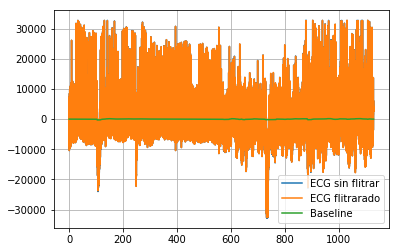

In [8]:
#------ Interpolacion -------
n_new                   = np.arange( cant_muestras )

ni                          = np.zeros( len(baseline_BF)+1 )
ni[0:len(baseline_BF)]      = range(int(cant_muestras/D))
ni[0:len(baseline_BF)]      = ni[0:len(baseline_BF)]*D
ni[len(baseline_BF)]        = cant_muestras -1

baseline_BF_aux                         = np.zeros( len(baseline_BF)+1 )
baseline_BF_aux[0:len(baseline_BF)]     = baseline_BF

f = interpol.interp1d( ni, baseline_BF_aux,       kind='cubic')
baseline_AF = f(n_new)

#------Diseño de Filtro-------
wpb_p_3         = 0.2               #Hz
wpb_s_3         = nyq_frec_3/D        #Hz
cant_coef_3     = 151

fir_coeff_pb_3 = myF.diseñoPB( fs, wpb_p_3, wpb_s_3, cant_coef_3)

#------Primer Filtrado-------
baseline = sig.lfilter(fir_coeff_pb_3, 1, baseline_AF)

#------Sustracción de Linea de Base-------
ecg_F = ecg_one_lead - baseline

#------Ploteo de la Linea de Base-------
plt.figure(10)

plt.plot(t, ecg_one_lead,  label='ECG sin flitrar')
plt.plot(t, ecg_F,     label='ECG flitrarado')
plt.plot(t, baseline,  label='Baseline')
plt.grid()
plt.legend()

plt.show()

Como se puede notar la Baseline no fue estimada de la forma que se esperaba y la señal quedó practicamente de la misma forma luego del filtrado, esto se debe a que se redujo más de lo que se debía la frecuencia. En el siguiente notbook se buscará cual es la frecuencia de resampleo más apta, o entre que rangos se puede ubicar, para reducir el tiempo de procesamiento pero sin dejar de realizar un buen filtrado